In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.utils import resample

In [4]:
path = "/content/data-bank.csv"
df = pd.read_csv(path)

In [5]:
target = "Bankrupt?" if "Bankrupt?" in df.columns else [c for c in df.columns if df[c].nunique()==2][0]
df[target] = df[target].astype(int)

In [6]:
print(df.shape)
print(df[target].value_counts())

(6819, 96)
Bankrupt?
0    6599
1     220
Name: count, dtype: int64


In [7]:
numeric = df.select_dtypes(include=[np.number]).columns.tolist()
numeric.remove(target)
corrs = df[numeric].corrwith(df[target]).abs().sort_values(ascending=False)
print(corrs.head(15))

Net Income to Total Assets                                 0.315457
ROA(A) before interest and % after tax                     0.282941
ROA(B) before interest and depreciation after tax          0.273051
ROA(C) before interest and depreciation before interest    0.260807
Debt ratio %                                               0.250161
Net worth/Assets                                           0.250161
Persistent EPS in the Last Four Seasons                    0.219560
Retained Earnings to Total Assets                          0.217779
Net profit before tax/Paid-in capital                      0.207857
Per Share Net profit before tax (Yuan ¥)                   0.201395
Current Liability to Assets                                0.194494
Working Capital to Total Assets                            0.193083
Net Income to Stockholder's Equity                         0.180987
Borrowing dependency                                       0.176543
Current Liability to Current Assets             

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


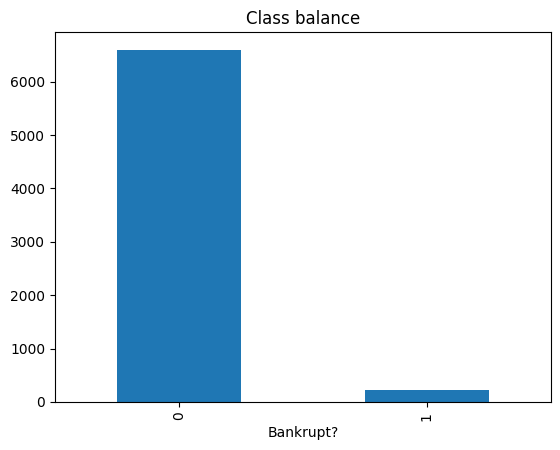

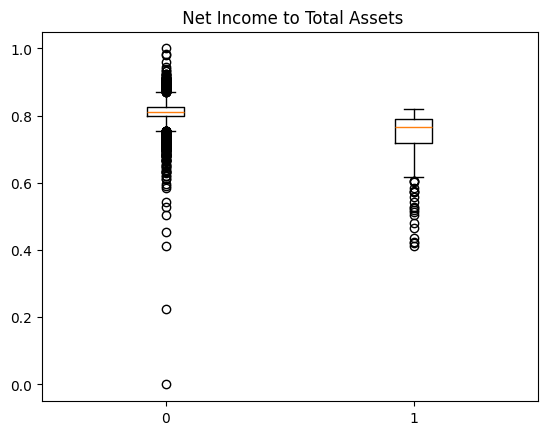

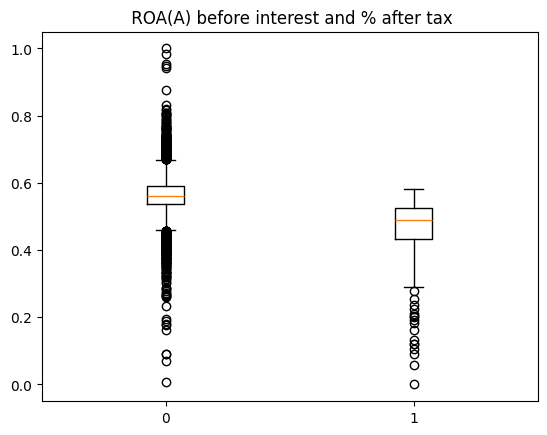

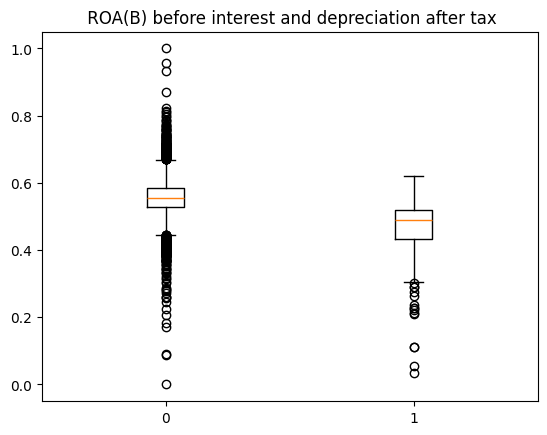

In [21]:
plt.figure(); df[target].value_counts().plot(kind='bar'); plt.title("Class balance"); plt.show()
for feat in corrs.head(3).index:
    plt.figure(); plt.boxplot([df[df[target]==0][feat].dropna(), df[df[target]==1][feat].dropna()], tick_labels=['0','1']); plt.title(feat); plt.show()


In [14]:
const_cols = [c for c in df.columns if df[c].nunique()<=1]
df = df.drop(columns=const_cols)
for c in df.select_dtypes(include=[np.number]).columns:
    df[c] = df[c].fillna(df[c].median())

In [15]:
X = df.drop(columns=[target])
y = df[target]
X = pd.get_dummies(X, drop_first=True)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

In [16]:
print("Before balancing:", y_train.value_counts())
train = pd.concat([X_train, y_train], axis=1)
major = train[train[target]==y_train.value_counts().idxmax()]
minor = train[train[target]==y_train.value_counts().idxmin()]
minor_upsampled = resample(minor, replace=True, n_samples=len(major), random_state=42)
train_up = pd.concat([major, minor_upsampled]).sample(frac=1, random_state=42)
X_train_bal = train_up.drop(columns=[target]); y_train_bal = train_up[target]
print("After balancing:", y_train_bal.value_counts())

Before balancing: Bankrupt?
0    4619
1     154
Name: count, dtype: int64
After balancing: Bankrupt?
1    4619
0    4619
Name: count, dtype: int64


In [17]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_bal)
X_test_s  = scaler.transform(X_test)


In [18]:
models = {
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, early_stopping=True, random_state=42)
}
results = {}
for name, m in models.items():
    print("Training", name)
    m.fit(X_train_s, y_train_bal)
    y_pred = m.predict(X_test_s)
    y_proba = m.predict_proba(X_test_s)[:,1] if hasattr(m, "predict_proba") else None
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    aucroc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(name, "confusion matrix:\n", cm)
    print(name, "classification report:\n", cr)
    print(name, "AUC:", aucroc)
    results[name] = {"model": m, "cm": cm, "cr": cr, "auc": aucroc}

Training DecisionTree
DecisionTree confusion matrix:
 [[1954   26]
 [  48   18]]
DecisionTree classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1980
           1       0.41      0.27      0.33        66

    accuracy                           0.96      2046
   macro avg       0.69      0.63      0.65      2046
weighted avg       0.96      0.96      0.96      2046

DecisionTree AUC: 0.6297979797979798
Training RandomForest
RandomForest confusion matrix:
 [[1964   16]
 [  47   19]]
RandomForest classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1980
           1       0.54      0.29      0.38        66

    accuracy                           0.97      2046
   macro avg       0.76      0.64      0.68      2046
weighted avg       0.96      0.97      0.96      2046

RandomForest AUC: 0.9364018977655341
Training MLP
MLP confusion matrix:
 

In [19]:
rf = models["RandomForest"]
if hasattr(rf, "feature_importances_"):
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("Top 10 features by RF importance:\n", importances.head(10))


Top 10 features by RF importance:
 Continuous interest rate (after tax)       0.079756
Borrowing dependency                       0.051417
Persistent EPS in the Last Four Seasons    0.046438
Equity to Liability                        0.043355
Debt ratio %                               0.041515
Retained Earnings to Total Assets          0.037237
Net worth/Assets                           0.036607
Net Income to Total Assets                 0.036276
Liability to Equity                        0.029469
Net profit before tax/Paid-in capital      0.027970
dtype: float64


In [20]:
from sklearn.metrics import precision_recall_curve
probs = rf.predict_proba(X_test_s)[:,1]
prec, rec, thr = precision_recall_curve(y_test, probs)
# find threshold achieving recall >= 0.6 (example)
desired_recall = 0.6
idx = np.where(rec >= desired_recall)[0]
if idx.size>0:
    t = thr[idx[0]]
    print("Threshold for recall >=", desired_recall, "is", t)
    y_thr = (probs >= t).astype(int)
    print("Confusion at that threshold:\n", confusion_matrix(y_test, y_thr))
else:
    print("No threshold found to reach desired recall on current model.")


Threshold for recall >= 0.6 is 0.0
Confusion at that threshold:
 [[   0 1980]
 [   0   66]]
